In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names

csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
     ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='password',
    database='targetecommerce'
)
cursor = conn.cursor()

# # Folder containing the CSV files
folder_path = 'C:\\Users\\Pracheta\\Desktop\\E-Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# # Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             user = "root",
                             password = "Pracheta@23",
                             database = "targetecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """SELECT DISTINCT customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
print(data)

[('franca',), ('sao bernardo do campo',), ('sao paulo',), ('mogi das cruzes',), ('campinas',), ('jaragua do sul',), ('timoteo',), ('curitiba',), ('belo horizonte',), ('montes claros',), ('rio de janeiro',), ('lencois paulista',), ('caxias do sul',), ('piracicaba',), ('guarulhos',), ('pacaja',), ('florianopolis',), ('aparecida de goiania',), ('santo andre',), ('goiania',), ('cachoeiro de itapemirim',), ('sao jose dos campos',), ('sao roque',), ('camacari',), ('resende',), ('sumare',), ('novo hamburgo',), ('sao luis',), ('sao jose',), ('santa barbara',), ('ribeirao preto',), ('ituiutaba',), ('taquarituba',), ('sao jose dos pinhais',), ('barrinha',), ('parati',), ('dourados',), ('trindade',), ('cascavel',), ('fortaleza',), ('brasilia',), ('pelotas',), ('porto alegre',), ('salto',), ('jundiai',), ('cacapava',), ('sao vicente',), ('uberlandia',), ('botelhos',), ('sao goncalo',), ('araucaria',), ('nova iguacu',), ('areia branca',), ('campos dos goytacazes',), ('sao carlos',), ('itajuba',), (

# Count the number of orders placed in 2017.

In [4]:
query = """SELECT Count(order_id) FROM orders Where year(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()
print(data[0][0])

45101


# Find the total sales per category.

In [6]:
query = """SELECT 
    upper(pr.product_category),
    ROUND(SUM(p.payment_value),2) AS total_payment
FROM Payments p
LEFT JOIN order_items o ON p.order_id = o.order_id
LEFT JOIN products pr ON pr.product_id = o.product_id
GROUP BY pr.product_category;
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
print(df)

                           Category       Sales
0              COMPUTER ACCESSORIES  1585330.45
1                            BABIES   539845.66
2                               PCS   279121.55
3                   WATCHES PRESENT  1429216.68
4   CONSTRUCTION TOOLS CONSTRUCTION   241475.63
..                              ...         ...
69                          FLOWERS     2213.01
70  KITCHEN PORTABLE AND FOOD COACH     4335.65
71                  HOUSE COMFORT 2     1710.54
72       CITTE AND UPHACK FURNITURE     5998.54
73                   CDS MUSIC DVDS     1199.43

[74 rows x 2 columns]


# Calculate the percentage of orders that were paid in installments.

In [8]:
query = """ SELECT (SUM( CASE WHEN payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments"""

cur.execute(query)
data = cur.fetchall()
print(data[0][0])

99.9981


# Count the number of customers from each state.

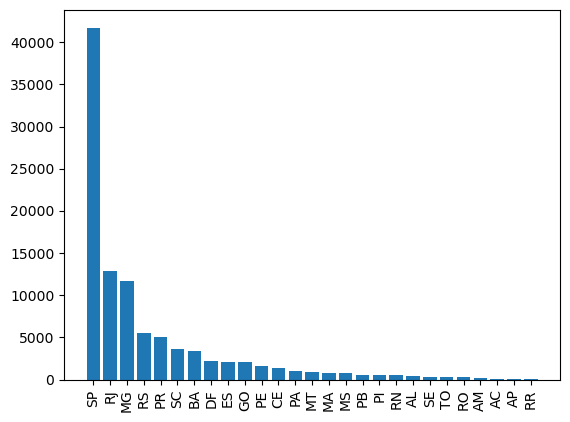

In [9]:
query = """ select customer_state, count(customer_id)
FROM customers
Group By customer_state"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.show()

# Calculate the number of orders per month in 2018.

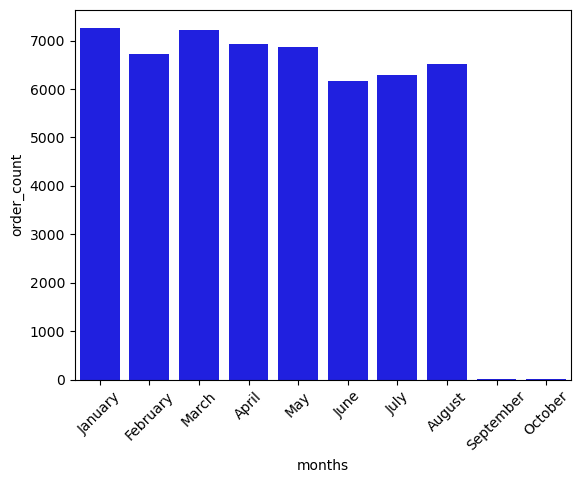

In [13]:
query = """ Select monthname(order_purchase_timestamp) months, count(order_id)
from orders where year(order_purchase_timestamp) = 2018
Group by months"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]

sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o, color = "Blue")
plt.xticks(rotation=45)
plt.show()

# Find the average number of products per order, grouped by customer city.

In [15]:

query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc), 2) avg_orders
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Prouducts", "AvgOrder"])
print(df)

                 Prouducts AvgOrder
0                sao paulo     1.16
1      sao jose dos campos     1.14
2             porto alegre     1.17
3                  indaial     1.12
4             treze tilias     1.27
...                    ...      ...
4105            japaratuba     1.00
4106        sebastiao leal     1.00
4107                buriti     3.00
4108  morro agudo de goias     1.00
4109         padre paraiso     1.00

[4110 rows x 2 columns]


# Calculate the percentage of total revenue contributed by each product category.

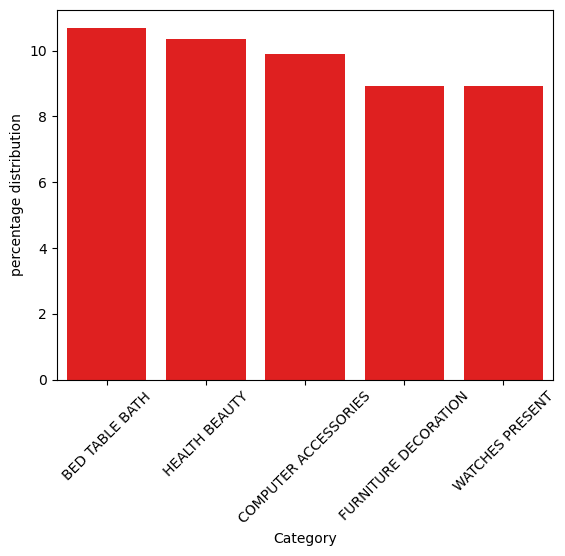

In [23]:

query = """SELECT 
    upper(pr.product_category),
     round((SUM(p.payment_value)/(select sum(payment_value) from payments))*100, 2) AS total_payment
FROM Payments p
LEFT JOIN order_items o ON p.order_id = o.order_id
LEFT JOIN products pr ON pr.product_id = o.product_id
GROUP BY pr.product_category;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "percentage distribution"])
df = df.sort_values(by="percentage distribution", ascending=False)

top5 = df.head(5)

sns.barplot(x=top5["Category"], y=top5["percentage distribution"], color="red")
plt.xticks(rotation=45)
plt.show()


# Identify the correlation between product price and the number of times a product has been purchased.

In [24]:
query = """select products.product_category,
count(order_items.product_id), round(avg(order_items.price),2) as price
from products 
join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]
print(np.corrcoef([arr1, arr2]))

[[ 1.         -0.10631514]
 [-0.10631514  1.        ]]
